In [1]:
import numpy as np
import pandas as pd
from pyod.utils.data import generate_data
from pyod.models.hbos import HBOS
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [183]:
# Importando los datos
emicron = pd.read_excel('emicron_21_final_ambulantes.xlsx')

In [233]:
#emicron['p3053'].head()
emicron.shape
#emicron['id'].head()
#len(emicron)

(2702, 142)

In [206]:
# Identificando las columnas que tienen 0 o nulos en todas sus filas
#emicron['p3092'].head().unique()
columnas_con_nan = emicron.columns[emicron.isna().sum() == len(emicron)]

In [207]:
print(columnas_con_nan)

Index([], dtype='object')


In [194]:
# Eliminando las columnas que no se tienen en cuenta en el modelo (valores nulos e identificadores)
emicron.drop(['id', 'mes_ref', 'directorio', 'secuencia_p', 'secuencia_encuesta', 'p3095', 'p3096', 'p3055', 'p3097', 'p3056_d', 'p3057_d', 'p3092', 'p3093', 'p4017', 'p4018', 'p4031', 'p4032'], axis = 1, inplace = True)

In [230]:
emicron.dtypes

cod_depto                     int64
area                        float64
clase_te                      int64
p35                           int64
p241                          int64
                             ...   
ventas_mes_anterior           int64
ventas_mes_anio_anterior    float64
ventas_anio_anterior        float64
valor_agregado                int64
ingreso_mixto                 int64
Length: 142, dtype: object

In [198]:
# Borrando las posibles filas que tengan valores vacíos en toda las variables
emicron.dropna(how = 'all', axis = 0)

,cod_depto,area,clase_te,p35,p241,p3031,p3032_1,p3032_2,p3032_3,p3033,...,p4028,p4029,p4030,p4038,p3072,ventas_mes_anterior,ventas_mes_anio_anterior,ventas_anio_anterior,valor_agregado,ingreso_mixto
0,73,73.0,1,2,35,1,0.0,0.0,1.0,2,...,0.0,0.0,0.0,NaN,180000,400000,NaN,800000.0,116000,116000
1,63,63.0,1,1,61,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,300000,870000,870000.0,7830000.0,300000,300000
2,76,76.0,1,2,49,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,700000,650000,800000.0,6000000.0,300000,300000
3,50,50.0,1,2,38,1,0.0,0.0,2.0,2,...,0.0,0.0,0.0,NaN,300000,700000,750000.0,7800000.0,274000,274000
4,5,5.0,1,2,47,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,50000,700000,NaN,5498833.0,450000,450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2697,50,50.0,1,2,51,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,750000,1500000,NaN,NaN,750000,750000
2698,50,50.0,1,1,25,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,500000,800000,NaN,NaN,490000,490000
2699,50,50.0,1,2,48,2,NaN,NaN,NaN,2,...,0.0,0.0,0.0,NaN,300000,700000,600000.0,5000000.0,320000,320000
2700,50,50.0,1,2,33,2,NaN,NaN,NaN,2,...,0.0,8750000.0,0.0,NaN,650000,1900000,1250000.0,8750000.0,660000,660000


In [205]:
# Reemplazando los valores nan por el promedio
emicron = emicron.fillna(emicron.mean())

In [235]:
# Verificando que no existan valores nulos en el dataset
print(f"¿Existen valores nulos?: {emicron.isnull().values.any()}. ¿Cunántos valores nulos hay?: {emicron.isnull().sum().sum()}")

Existen valores nulos?: True. Cunántos valores nulos hay 176253


In [217]:
# Dividiendo el dataset en datos de entrenamiento y datos de validación

X_train, X_test = train_test_split(emicron, test_size = 0.3, random_state = 0)

In [219]:
X_train.head()

cod_depto                   0
area                        0
clase_te                    0
p35                         0
p241                        0
                           ..
ventas_mes_anterior         0
ventas_mes_anio_anterior    0
ventas_anio_anterior        0
valor_agregado              0
ingreso_mixto               0
Length: 142, dtype: int64

In [220]:
print(f"El tamaño de los datos de entrenamiento es: {X_train.shape} y de validación: {X_test.shape}")

El tamaño de los datos de entrenamiento es: (1891, 142) y de validación: (811, 142)


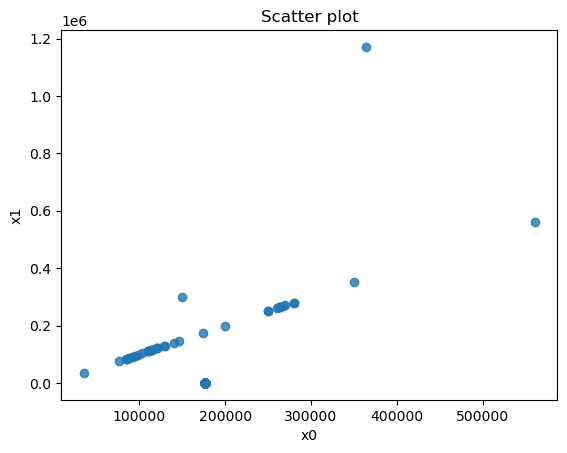

In [221]:
# Graficando las variables 0 y 1 en un scatter plot e identificando atípicos. Amarillo atípicos, morados, datos normales
plt.scatter(X_train['p3089'], X_train['prestaciones'], alpha = 0.8) # c es la lista de colores de acuerdo con los valores únicos de esta variable, la cual en la líne anterior es 1,0
plt.title("Scatter plot")
plt.xlabel('x0')
plt.ylabel('x1')
plt.show()

In [222]:
n_bins = 50
hbos = HBOS(n_bins = n_bins, contamination = 0.05)
hbos.fit(X_train)

HBOS(alpha=0.1, contamination=0.05, n_bins=50, tol=0.5)

In [223]:
print("El umbral para los datos de ratio contaminados: ", hbos.threshold_)

El umbral para los datos de ratio contaminados:  110.85820273826559


In [224]:
# Creando las puntuaciones para los datos de entrenamiento y prediciendo cuando una instancia es atípica o no
# la función predict compara la puntuación de los datos atípicoscon el umbral. Si la puntuación de un atípico es mayor al umbral, la función asigna 1, o en caso contrario , 0
# Datos de entrenamiento

Y_train_scores = hbos.decision_function(X_train)
Y_train_pred = hbos.predict(X_train)

# Datos de testeo o validación
Y_test_scores = hbos.decision_function(X_test)
Y_test_pred = hbos.predict(X_test)

In [225]:
Y_train_pred
#contanto el número de valores predichos
def count_stat(vector):
    unique, counts = np.unique(vector,
                               return_counts = True)
    return dict(zip(unique, counts))

print("Los datos de entrenamiento: ", count_stat(Y_train_pred))
print("Los datos de validación o test: ", count_stat(Y_test_pred))

Los datos de entrenamiento:  {0: 1796, 1: 95}
Los datos de validación o test:  {0: 774, 1: 37}


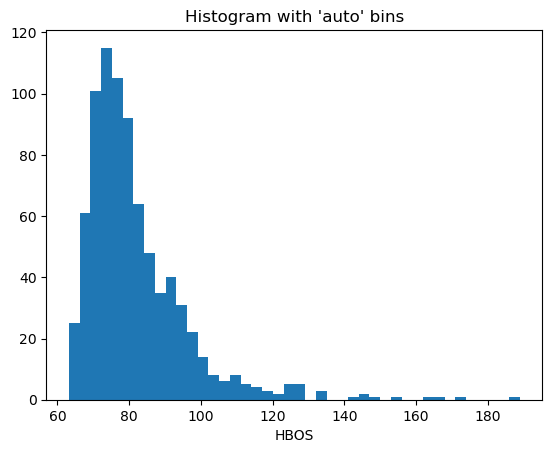

In [226]:
plt.hist(Y_test_scores, bins = 'auto')
plt.title("Histogram with 'auto' bins")
plt.xlabel('HBOS')
plt.show()